# $k$-means Clustering and DBScan

Let's begin with an explanation of clustering. With clustering, the goal is to paritition a set of data points into groups such that data points in a cluster have similar characteristics and features. In this notebook, we will focus on two clustering techniques: k-means and DBScan. However, other clustering techniques exist as well, including hierarchical clustering and Gaussian mixture models. 


K-means clustering is an unsupervised ML technique that partititions a dataset into K clusters, where K is a hyperparameter chosen by the user. 

The main steps are as follows:

1) Initialization- K cluster centroids (centers for our clusters) are initialized randomly.
2) Assignment- each datapoint is assigned to the nearest centroid by using a distance metric. In our case, it will be Euclidian distance, but other metrics are also valid.
3) Adjustment- based on the assignments, the centroid is recalculated to fit the mean of the points assigned.
4) Iterate- steps 2 and 3 are repeated until convergence. That is, the centroids change very little and remain stable.


On the other hand, DBSCAN (Density Based Spatial Clustering of Application with Noise) operates based on the idea of density, where clusters are defined as dense, closely-packed regions of data points, while low density data is considered as noise.

The main steps are as follows:

1) Initalize the algorithm and define 2 paramaters: eps, which is the max distance between 2 points to be considered neighbors, and minPts, which is the minimum number of points required for a region to be considered dense
2) Starting from an arbitrary point, the algorithm determines border/noise points and core points absed on the parameters defined from above. 
3) Clusters are formed by connecting core points to neighboring points. 
4) Noise points are considered outliers.
5) Repeat for all points.

Here is a visual that shows the resulting differences between these two clustering techniques:

![k means and db scan](kmeans&dbscan.png)

# Application: K-Means

In this notebook, we will once again analyze the heart attack dataset (see description of its specific features in the Logistic Regression notebook). 

In the original notebook, the "target" feature indicated whether or not someone had a heart attack. If a patient had a target feature of "0", then they did not have a heart attack, while a target feature of "1" means that they did. 

For the sake of this notebook, we will pretend that this column does not exist, and we are only given data on the different qualities of the patient. We will attempt to cluster this data based on two qualities: resting blood pressure (trestbps) and maximum heart rate (thalach).

The example feels a bit trivial, as heart attack information is probably used to trace back warning signs, instead of the other way around, but let's try this for the sake of experiment!

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme()

df= pd.read_csv(r"C:\Users\faith\inde 577\INDE577\577repo\Supervised Learning\Datasets\heart.csv")
df= df.dropna()
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Given that we have the target label here, we will visualize how the actual data looks like. Notice that there is significant overlap between heart attacks and no heart attacks, which will pose a challenge for our clustering algorithms.

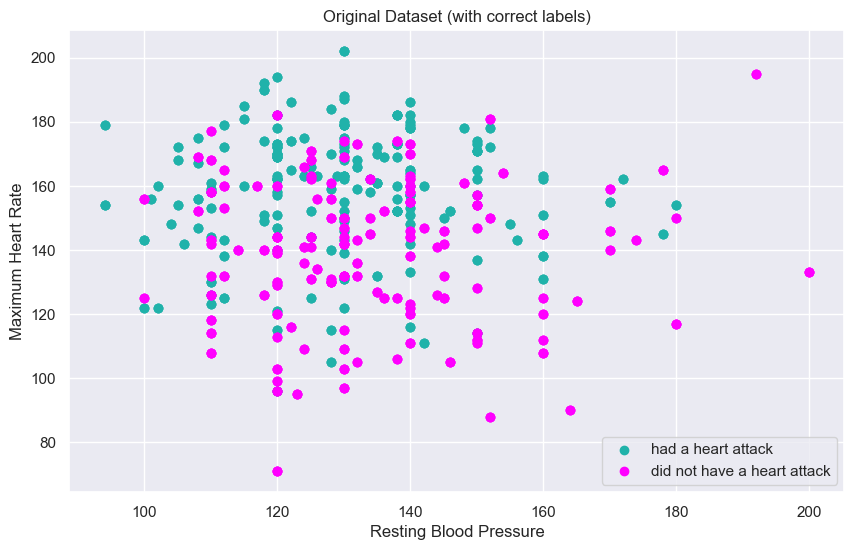

In [18]:
die = df[df['target'] == 1]
live = df[df['target'] == 0]


plt.figure(figsize=(10, 6))
plt.scatter(die['trestbps'], 
            die['thalach'], 
            color='lightseagreen', 
            label='had a heart attack')

plt.scatter(live['trestbps'], 
            live['thalach'], 
            color='magenta', 
            label='did not have a heart attack')

plt.title('Original Dataset (with correct labels)')
plt.xlabel('Resting Blood Pressure')
plt.ylabel('Maximum Heart Rate')
plt.legend()
plt.show()

This is how the original data looks like. The sea green represents someone who had a heart attack, while the magenta represents someone who did not have a heart attack. The next thing we will do is ignore these labels and assume we only have resting blood pressure and maximum herat rate to work with.

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X = df.loc[:, ['trestbps', 'thalach']]

We will choose k to be = 2, because these are our two categories: had a heart attack or did not have a heart attack. However, we are free to technically choose any k that we want.

In [29]:
# standardizing the features
scaler = StandardScaler()
X_standard = scaler.fit_transform(X)
X_standardized = pd.DataFrame(X_standard, columns=X.columns)

#2 clusters with 10 iterations
kmeans = KMeans(n_clusters=2, n_init= 30, random_state=42) 
kmeans.fit(X)
labels = kmeans.predict(X_standardized)

cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_


[0 0 1 ... 1 0 1]


Next, we plot our results side by side with the original dataset. Let's see how close k-means got to the actual labels.

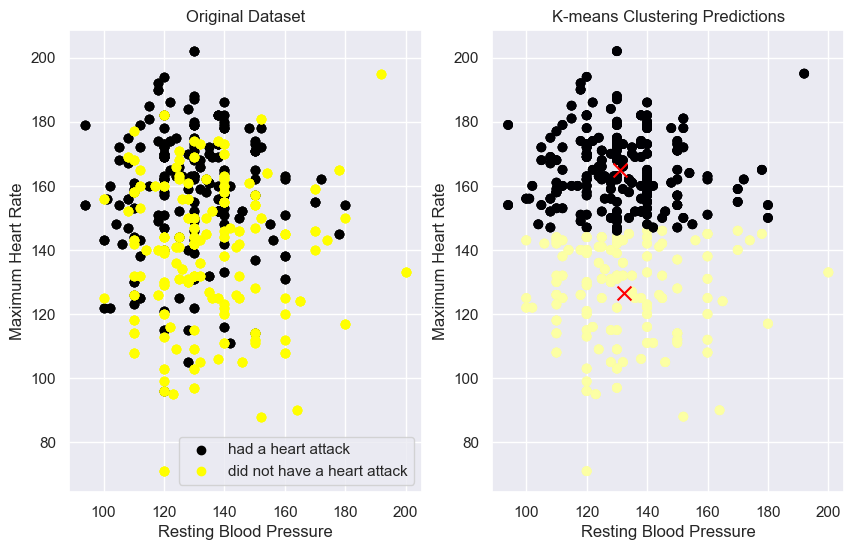

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 6))


ax1.scatter(die['trestbps'], 
            die['thalach'], 
            color='black', 
            label='had a heart attack')

ax1.scatter(live['trestbps'], 
            live['thalach'], 
            color='yellow', 
            label='did not have a heart attack')

ax1.set_title('Original Dataset')
ax1.set_xlabel('Resting Blood Pressure')
ax1.set_ylabel('Maximum Heart Rate')
ax1.legend()

ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], c=cluster_labels, cmap='inferno')
ax2.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red', label='Centroids')
ax2.set_title('K-means Clustering Predictions')
ax2.set_xlabel('Resting Blood Pressure')
ax2.set_ylabel('Maximum Heart Rate')
plt.show()

So not bad! I think something really funny about K-means is that it will literally just consider the datapoints closest to the centroid as part of the cluster. This is why you see such a hard divide between the two sides on the cluster side, while there is a lot more overlap on the original dataset side. We can contexualize this by doing a brief error analysis:

In [30]:
from sklearn.metrics import adjusted_rand_score

y_true= df.target
y_pred= cluster_labels

ari = adjusted_rand_score(y_true, y_pred)
print("Adjusted Rand Index (ARI):", ari)


Adjusted Rand Index (ARI): 0.17111971239034018


ARI index is a measure of accuracy that reads as follows: -1 -> disagreement between clusterings, 0 -> random labeleing, 1 -> perfect agreement.

So and ARI score of 0.17 is not bad! It's definitely better than random labeling.

# Application: DBScan

Next, let's implement DBScan on the same dataset.

In [72]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

X = df.loc[:, ['trestbps', 'thalach']]


scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)

dbscan = DBSCAN(eps= 4, min_samples=5)
dbscan.fit(X)
dblabels = dbscan.fit_predict(X)

print(dblabels[:100])

[ 0  0  1  2 -1  3  4  5  4  6  7  0  8  9  0  8  0 -1  0  0  0  4 -1  0
 10  0  0  0  0 -1  4  0 11 12  0 13 -1 14 15  0 -1  4  0  4  0 14  0 -1
  0  0  2  9  0  4 16 16  0  0 13 -1 -1  0  3 17 -1 18  0  9 10  5 -1  0
  0  0  0  0 10  0  0  0  0 19 13  0 10 10  0 -1  0  0 20  0  0  4  0  0
  0 21  0  9]


I had to play with the eps value quite a bit to get a better prediction of the labels. eps was intially set to 0.5, but this caused too many clusters, while setting eps to a large number like 10 caused too general clusters. The variability of eps, along with min_samples, is definitely one of the weaknesses of DBScan.

Next, we will visualize DBScan in comparison to the original data.

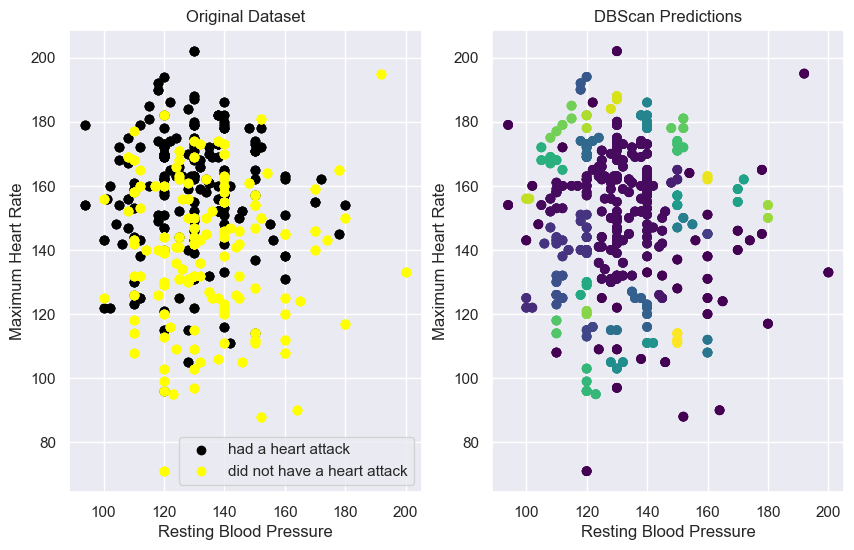

In [73]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 6))


ax1.scatter(die['trestbps'], 
            die['thalach'], 
            color='black', 
            label='had a heart attack')

ax1.scatter(live['trestbps'], 
            live['thalach'], 
            color='yellow', 
            label='did not have a heart attack')

ax1.set_title('Original Dataset')
ax1.set_xlabel('Resting Blood Pressure')
ax1.set_ylabel('Maximum Heart Rate')
ax1.legend()

ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], c=dblabels, marker = 'o', cmap='viridis')
ax2.set_title('DBScan Predictions')
ax2.set_xlabel('Resting Blood Pressure')
ax2.set_ylabel('Maximum Heart Rate')
plt.show()

In [78]:
ari = adjusted_rand_score(y_true, dblabels)

print("ARI score:", ari)

ARI score: 0.007178882096697581


So DBScan is doing worse than k-means, for sure! Although we only have 2 clusters, DBScan has identified 10+ different ones, as seen by the scatter plots that basically don't look alike at all lol. Additionally, the ARI score is so close to 0, meaning the assignment of cluster labels is almost the same as random assignment.

Because there is so much overlap in this dataset, it's difficult for DBScan to accurately identify the clusters. Indeed, DBScan additionally struggles with datsets that have clusters of varying densities, and in this case, struggles with the different parameter values. I feel as if DBScan applied to this dataset is like trying to do a realistic drawing with crayons- a too general algorithm for very specific data.

Still, DBScan is pretty good to datasets unlike these- it's good for robustness for noise and can identify arbitrary-shaped clusters. 

Next, we will discuss the last technique of this repository- PCA!